In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem.rdMolAlign import AlignMolConformers, AlignMol
from rdkit.Chem.Draw import rdMolDraw2D
from conf_ensemble_library import ConfEnsembleLibrary
from pdbbind_metadata_processor import PDBBindMetadataProcessor
from molconfviewer import MolConfViewer
from litschnet import LitSchNet
from molecule_featurizer import MoleculeFeaturizer
from torch_geometric.data import Batch
from ConfScorer import ConfAnalyzer
from sklearn.metrics import r2_score
from energy_calculator import XtbEnergyCalculator
from rdkit.Chem.rdMolTransforms import SetDihedralDeg, GetDihedralDeg
from collections import namedtuple, defaultdict

In [2]:
def get_model() :
    split = 'protein'
    iteration = 2
    experiment_name = f'{split}_split_{iteration}'
    checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
    model = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    model.eval()
    return model

In [3]:
def save_2d_depiction(mol, path, atom_indices=False) :
    d2d = rdMolDraw2D.MolDraw2DCairo(700, 700)
    if atom_indices :
        d2d.drawOptions().addAtomIndices=True
    mol_copy = copy.deepcopy(mol)
    mol_copy.RemoveAllConformers()
    d2d.DrawMolecule(mol_copy)
    d2d.FinishDrawing()
    d2d.WriteDrawingText(path) 

In [4]:
def get_most_similar_mol_in_train(test_mol, train_fps) :
    test_fp = AllChem.GetMorganFingerprint(test_mol, 3, useChirality=True)
    sims = []
    for train_fp in train_fps :
        dice_sim = DataStructs.TanimotoSimilarity(test_fp, train_fp)
        sims.append(dice_sim)
    max_sim_idx = np.argmax(sims)
    print('Tanimoto similarity: ', np.max(sims))
    sim_smiles = train_smiles[max_sim_idx]

    sim_ce = cel.load_ensemble_from_smiles(sim_smiles, load_dir='merged')
    return sim_ce.mol

In [5]:
fields = ['torsion_atoms', 'angles', 'energies', 'preds']
TorsionAnalysisResults = namedtuple("TorsionAnalysisResult", fields)

def analyze_torsion(torsion_atoms, mol) :
    data_list = mf.featurize_mol(mol)
    angles = range(-180, 180, 5)
    energies = []
    explore_data_list = []
    for angle in angles :
        dummy_mol = copy.deepcopy(mol) 
        conf = dummy_mol.GetConformer(0)
        #import pdb; pdb.set_trace()
        SetDihedralDeg(conf, *torsion_atoms, angle)

        energy = xtb_calculator.get_energy(dummy_mol)
        energies.append(energy)
        
        mol_noh = Chem.RemoveHs(dummy_mol)
        data = mf.conf_to_data(rdkit_mol=mol_noh, 
                               conf_id=0, 
                               edge_index=data_list[0].edge_index,
                               x=data_list[0].x)
        explore_data_list.append(data)
        
    model = get_model()
    batch = Batch.from_data_list(explore_data_list)
    preds = model(batch)
    preds = preds.detach().numpy().reshape(-1)
    
    results = TorsionAnalysisResults(torsion_atoms, 
                                     angles, 
                                     energies,
                                     preds)
        
    return results
        
def plot_torsion_analysis(results: TorsionAnalysisResults) :  

    torsion_atoms = results.torsion_atoms
    angles = results.angles
    energies = results.energies
    preds = results.preds
    
    bioactive_mol = copy.deepcopy(mol)
    bioactive_mol.RemoveAllConformers()
    bioactive_mol.AddConformer(mol.GetConformers()[-1], assignId=True)
    generated_mol = copy.deepcopy(mol)
    generated_mol.RemoveConformer(100)

    mol_dict = {'Bioactive': bioactive_mol,
                'Generated': generated_mol}
    ca.plot_dihedrals_histograms([torsion_atoms], mol_dict)
    
    df = pd.DataFrame({'Dihedral angle (Deg)' : angles,
                       'ARMSD prediction' : preds,
                       'Energy (eV)' : energies})
    bio_deg = GetDihedralDeg(mol.GetConformers()[-1], *torsion_atoms)
    
    with sns.plotting_context('talk') :
        sns.lineplot(data=df, 
                     x='Dihedral angle (Deg)', 
                     y='ARMSD prediction')
        plt.axvline(x=bio_deg, color='r', linestyle='-', label='Bioactive conformation')
        plt.legend(loc='upper right')
        plt.show()

        sns.lineplot(data=df, 
                     x='Dihedral angle (Deg)', 
                     y='Energy (eV)')
        plt.axvline(x=bio_deg, color='r', linestyle='-', label='Bioactive conformation')
        plt.legend(loc='upper right')
        plt.show()

In [6]:
split = 'protein'
iteration = 2
with open(os.path.join('data/', f'protein_similarity_splits', f'train_pdb_protein_similarity_split_{iteration}.txt'), 'r') as f :
    train_pdbs = f.readlines()
    train_pdbs = [pdb.strip() for pdb in train_pdbs]
smiles_df = pd.read_csv('data/smiles_df.csv')
train_smiles = smiles_df[(smiles_df['id'].isin(train_pdbs))
                        & smiles_df['included']]['smiles'].unique()

In [7]:
train_mols = [Chem.MolFromSmiles(smiles) for smiles in train_smiles]
train_fps = [AllChem.GetMorganFingerprint(mol, 3, useChirality=True) for mol in train_mols]

In [8]:
mcv = MolConfViewer()
mf = MoleculeFeaturizer()
ca = ConfAnalyzer()
xtb_calculator = XtbEnergyCalculator()

In [9]:
# look at the bioactive conformation identification performance of highly flexible molecules

mol_results_path = f'results/{split}_split_{iteration}_pdbbind/mol_results.p'
with open(mol_results_path, 'rb') as f :
    mol_results = pickle.load(f)

conf_results_path = f'results/{split}_split_{iteration}_pdbbind/conf_results.p'
with open(conf_results_path, 'rb') as f :
    conf_results = pickle.load(f)

In [63]:
rot_smiles = []
for smiles, results in mol_results.items() :
    if results['n_rotatable_bonds'] == 6 :
        rot_smiles.append(smiles)

In [64]:
active_smiles = []
for smiles in rot_smiles :
    mol_r = mol_results[smiles]
    if 'normalized_first_bioactive_like_rank' in mol_r :
        if (mol_r['normalized_first_bioactive_like_rank']['model'] == 0) and mol_r['n_actives'] < 5:
            active_smiles.append(smiles)

In [65]:
active_smiles

['Cc1[nH]nc2ccc(-c3cncc(OC[C@@H]([NH3+])Cc4c[nH]c5ccccc45)c3)cc12']

In [67]:
smiles = active_smiles[0]
cel = ConfEnsembleLibrary()
cel.load_metadata()
ce = cel.load_ensemble_from_smiles(smiles, 'merged')
mol = ce.mol
AlignMolConformers(mol)
print(mol_results[smiles]['normalized_first_bioactive_like_rank'])

{'model': 0.0, 'ccdc': 0.03, 'energy': 0.1, 'random': 0.26}


In [68]:
mcv.view(mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:', max=101), Output()), _dom_classes=(…

BoundedIntText(value=0, description='Conformer ID:', max=101)

In [69]:
save_2d_depiction(mol, 'mol_for_pres.png', atom_indices=True)

In [70]:
gen_mol = copy.deepcopy(mol)
gen_mol.RemoveConformer(100)
bio_mol = copy.deepcopy(mol)
bio_mol.RemoveAllConformers()
bio_mol.AddConformer(mol.GetConformer(100), assignId=True)
AlignMol(gen_mol, bio_mol)

3.3893559206375596

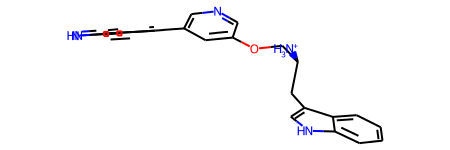

In [71]:
mol

In [72]:
with Chem.SDWriter('gen_mols.sdf') as sdwriter :
    for i in range(100) :
        sdwriter.write(gen_mol, confId=i)

with Chem.SDWriter('gen_mol.sdf') as sdwriter :
    sdwriter.write(gen_mol)

with Chem.SDWriter('bio_mol.sdf') as sdwriter :
    sdwriter.write(bio_mol)

In [73]:
pmp = PDBBindMetadataProcessor()
table = pmp.get_master_dataframe(remove_peptide_ligands=False)

In [74]:
#smiles = flexible_smiles[5]
#ce = cel.load_ensemble_from_smiles(smiles, load_dir='merged')
test_mol = ce.mol
pdb_id = ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active
16349,2jdv,2.08,2007,8.2,Ki=6.3nM //,2jdv.pdf,(L20),"[nM, =, 6.3]",=,6.3,nM,2007,P00517,CAMP-DEPENDENT PROTEIN KINASE,True


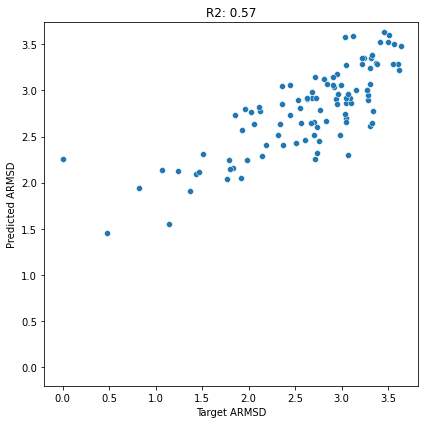

In [75]:
x = conf_results[smiles]['targets']
y = conf_results[smiles]['preds']
r2 = r2_score(x, y)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=x, y=y)
plt.xlim(-0.2)
plt.ylim(-0.2)
plt.xlabel('Target ARMSD')
plt.ylabel('Predicted ARMSD')
plt.title(f'R2: {r2:.2f}')
plt.tight_layout()
plt.savefig('large_mol_regression.png', dpi=300)

In [76]:
save_2d_depiction(test_mol, 'generated_ranking_results/test_mol.png')

AlignMolConformers(test_mol)
mcv.view(test_mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:', max=101), Output()), _dom_classes=(…

BoundedIntText(value=0, description='Conformer ID:', max=101)

In [77]:
sdwriter = Chem.SDWriter('generated_ranking_results/mol.sdf')
for conf in test_mol.GetConformers() :
    sdwriter.write(test_mol, confId=conf.GetId())
sdwriter.close()

In [78]:
train_mol = get_most_similar_mol_in_train(test_mol, train_fps)
pdb_id = train_mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

Tanimoto similarity:  1.0


,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active
16349,2jdv,2.08,2007,8.2,Ki=6.3nM //,2jdv.pdf,(L20),"[nM, =, 6.3]",=,6.3,nM,2007,P00517,CAMP-DEPENDENT PROTEIN KINASE,True


In [79]:
mcv.view(train_mol)

interactive(children=(BoundedIntText(value=0, description='Conformer ID:', max=101), Output()), _dom_classes=(…

BoundedIntText(value=0, description='Conformer ID:', max=101)

In [135]:
mcs = rdFMCS.FindMCS([test_mol, train_mol])
core = Chem.MolFromSmarts(mcs.smartsString)

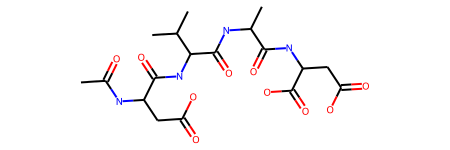

In [136]:
core

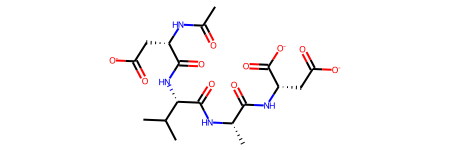

In [137]:
def mol_3d_to_2d(mol) :
    copy_mol = copy.deepcopy(mol)
    copy_mol.RemoveAllConformers()
    return copy_mol
copy_1 = mol_3d_to_2d(ce.mol)
copy_1

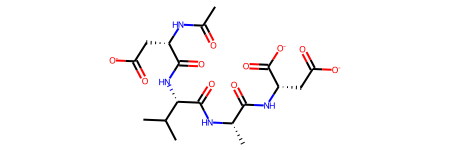

In [138]:
copy_2 = mol_3d_to_2d(train_mol)
copy_2

In [139]:
query_match = copy_1.GetSubstructMatch(core)
template_match = copy_2.GetSubstructMatch(core)
AllChem.Compute2DCoords(copy_1)
AllChem.Compute2DCoords(copy_2)
rms = AlignMol(copy_1, copy_2, atomMap=list(zip(query_match,template_match)))
save_2d_depiction(copy_1, 'generated_ranking_results/mol1.png')
save_2d_depiction(copy_2, 'generated_ranking_results/mol2.png')

In [140]:
model = get_model()
model.eval()
import torch
with torch.no_grad() :
    model.show_atomic_contributions(test_mol, suffix='Test', savedir='generated_ranking_results/')
    model.show_atomic_contributions(train_mol, suffix='Similar_train', savedir='generated_ranking_results/')

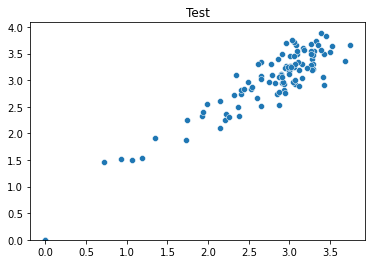

In [141]:
with torch.no_grad() :
    mol_featurizer = MoleculeFeaturizer()
    data_list = mol_featurizer.featurize_mol(test_mol)
    batch = Batch.from_data_list(data_list)
    rmsds = mol_featurizer.get_bioactive_rmsds(test_mol)
    preds = model(batch).reshape(-1)
    sns.scatterplot(x=rmsds, y=preds)
    plt.ylim(0)
    plt.title('Test')
    plt.show()

In [143]:
preds.argsort()

tensor([101, 100,  19,  95,  63,  90,  81,  23,  83,  32,  89,  85,  12,   8,
          9,  92,  48,  33,  88,  64,  69,  38,  10,  46,  34,  96,  68,  47,
         49,  16,  53,  40,  35,  43,  52,   4,  37,   1,  72,  39,  75,  62,
         57,  84,  66,  94,  77,  73,  20,  71,  21,  98,  58,  50,  44,  86,
         17,  65,  22,  87,  28,  59,  91,  74,  55,  11,  80,  61,  60,  99,
         45,  13,  42,  27,  54,   3,  14,  76,  36,  30,  97,   6,  31,  79,
         82,  41,  25,  18,  93,  67,   0,   5,  24,  56,  15,   7,  78,  26,
         29,  70,  51,   2])

In [144]:
import importlib
import mol_drawer
importlib.reload(mol_drawer)
MolDrawer = mol_drawer.MolDrawer

In [145]:
data_list = mf.featurize_mol(test_mol)
batch = Batch.from_data_list(data_list)
ac = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac = ac.reshape(test_mol.GetNumConformers(), test_mol.GetNumAtoms())
preds = model(batch)
preds = preds.detach().numpy().reshape(-1)

In [146]:
diff = grouped_ac[2] - grouped_ac[100]

In [147]:
MolDrawer().plot_values_for_mol(mol=test_mol, values=diff, suffix='diff_02_100', save_dir='atomic_contributions_diff')

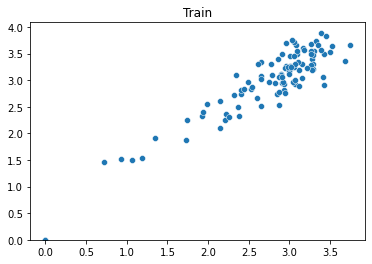

In [148]:
with torch.no_grad() :
    data_list = mol_featurizer.featurize_mol(train_mol)
    batch = Batch.from_data_list(data_list)
    rmsds = mol_featurizer.get_bioactive_rmsds(train_mol)
    preds = model(batch).reshape(-1)
    sns.scatterplot(x=rmsds, y=preds)
    plt.ylim(0)
    plt.title('Train')
    plt.show()

In [37]:
preds.argsort()

tensor([ 55, 100,  22,  18,  77,  79,  10,  80,  11,  88,  92,  64,  20,  23,
         28,  86,  24,  91,  27,  26,  19,  54,  85,   9,  66,  62,  87,  57,
         99,  97,  98,  25,  68,  78,   8,  46,  29,  67,  47,  56,  74,  63,
         65,  21,  73,  69,  50,  75,  49,  48,  90,  42,   1,  51,  30,  93,
         31,  43,   0,  44,  16,  45,  14,  72,  12,   6,   3,  96,  15,  95,
         17,   7,  89,   2,  36,  94,  13,  61,  76,  70,   5,  60,  38,  81,
         83,   4,  33,  52,  71,  40,  32,  53,  58,  82,  41,  35,  84,  59,
         37,  39,  34])

In [89]:
data_list = mf.featurize_mol(train_mol)
batch = Batch.from_data_list(data_list)
ac = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac = ac.reshape(train_mol.GetNumConformers(), train_mol.GetNumAtoms())
preds = model(batch)
preds = preds.detach().numpy().reshape(-1)

In [90]:
diff = grouped_ac[34] - grouped_ac[100]

In [93]:
MolDrawer().plot_values_for_mol(mol=train_mol, values=diff, suffix='diff_34_100_trian', save_dir='atomic_contributions_diff')

In [55]:
batch_i = 0
pred_is = atomic_contributions[batch.batch == batch_i]
pred_is = pred_is.numpy()

In [62]:
float(pred_is[i][0])

-0.01201905868947506

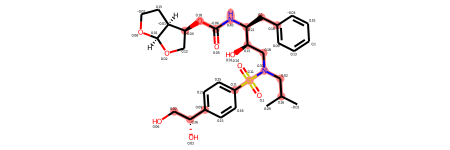

In [79]:
copy_mol = copy.deepcopy(test_mol)
Chem.rdDepictor.Compute2DCoords(copy_mol)
for i, at in enumerate(copy_mol.GetAtoms()) :
    value = str(round(float(pred_is[i][0]), 2))
    at.SetProp('atomNote', value)
copy_mol

In [81]:
save_2d_depiction(copy_mol, 'generated_ranking_results/test_mol.png')

In [42]:
bioactive_mol = copy.deepcopy(test_mol)
bioactive_mol.RemoveAllConformers()
bioactive_mol.AddConformer(test_mol.GetConformer(100), assignId=True)
generated_mol = copy.deepcopy(test_mol)
generated_mol.RemoveConformer(100)

mol_dict = {'Bioactive': bioactive_mol,
            'Generated': generated_mol}

In [43]:
preds.argsort()

array([100,   3,  18,  63,  77,  94,  47,  38,  54,  57,  30,  60,  14,
        78,  46,  91,  86,  92,  37,  28,  16,  59,  89,  71,  23,  62,
         7,  95,  65,  67,  70,   9,  50,  84,  48,  96,  44,  34,  33,
        11,   1,  24,  53,  10,  90,  81,  45,  17,  85,  41,  69,  22,
        87,  27,  26,  49,  58,  97,  42,  79,  29,  12,  82,  80,  76,
        75,   5,  40,  55,  99,  52,  15,  72,   4,  88,  39,   8,  36,
        66,  74,  31,   2,   0,  20,  35,   6,  51,  73,  93,  43,  83,
        19,  25,  13,  68,  64,  98,  32,  21,  61,  56])

In [1]:
import importlib
import ConfScorer
importlib.reload(ConfScorer)
ca = ConfScorer.ConfAnalyzer()

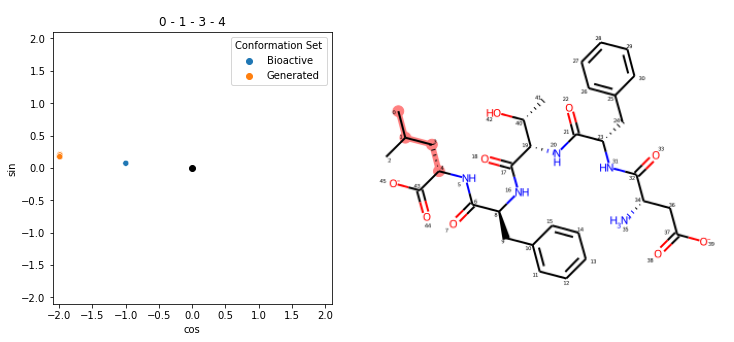

<Figure size 432x288 with 0 Axes>

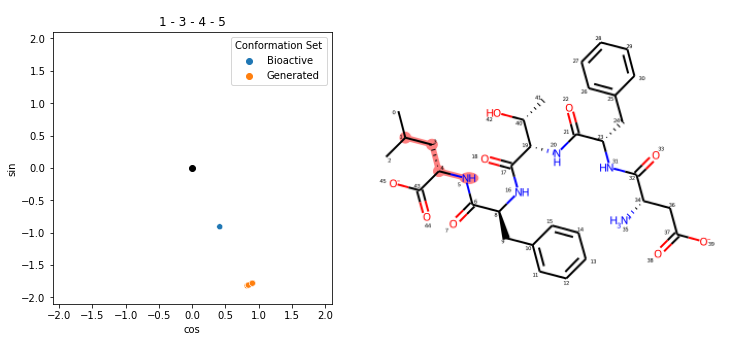

<Figure size 432x288 with 0 Axes>

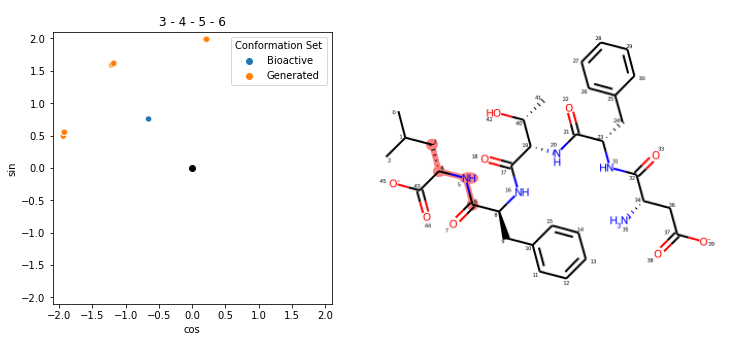

<Figure size 432x288 with 0 Axes>

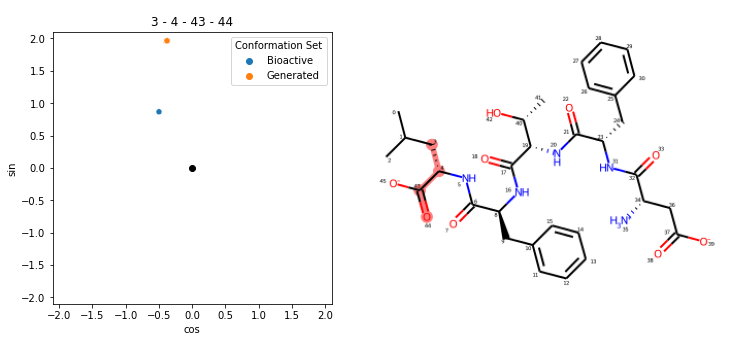

<Figure size 432x288 with 0 Axes>

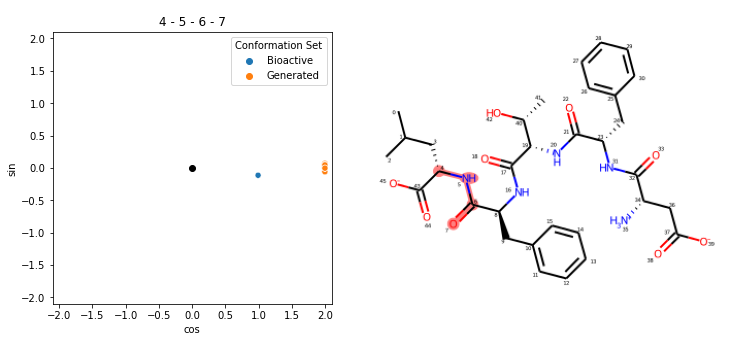

<Figure size 432x288 with 0 Axes>

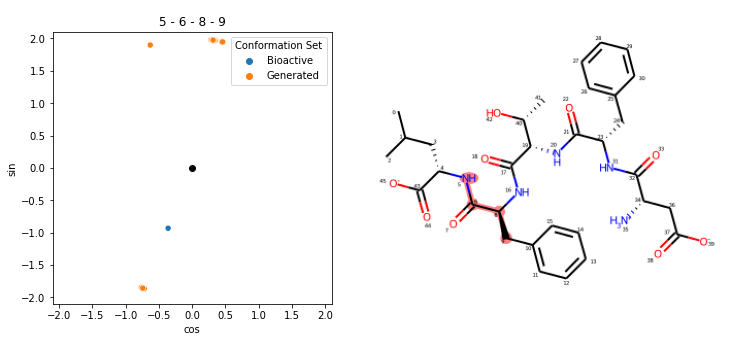

<Figure size 432x288 with 0 Axes>

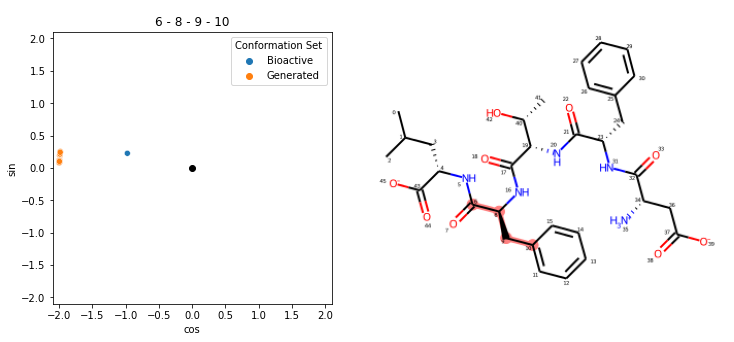

<Figure size 432x288 with 0 Axes>

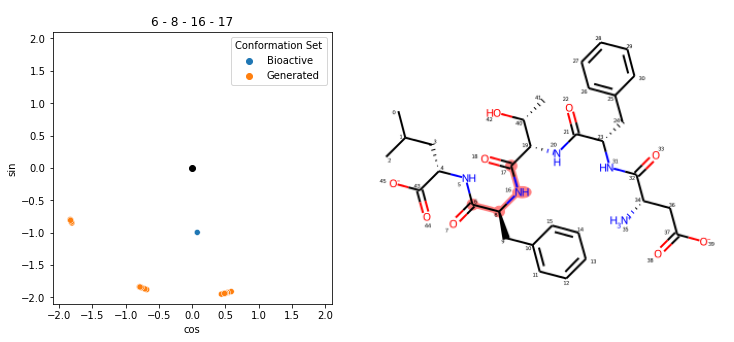

<Figure size 432x288 with 0 Axes>

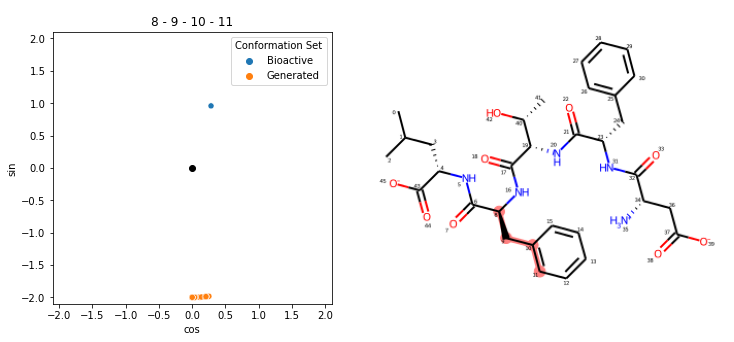

<Figure size 432x288 with 0 Axes>

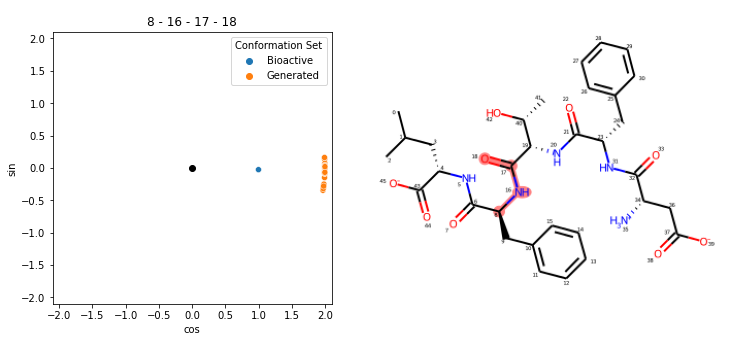

<Figure size 432x288 with 0 Axes>

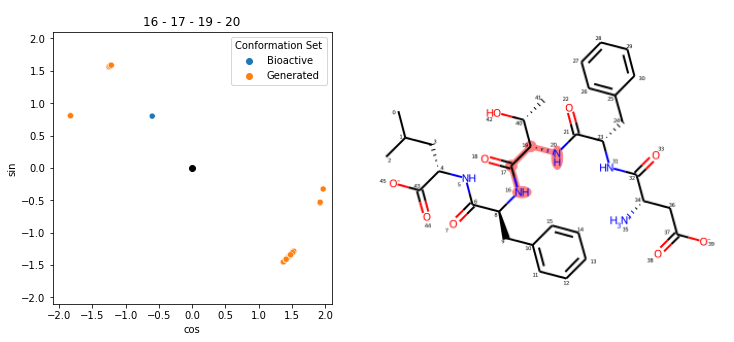

<Figure size 432x288 with 0 Axes>

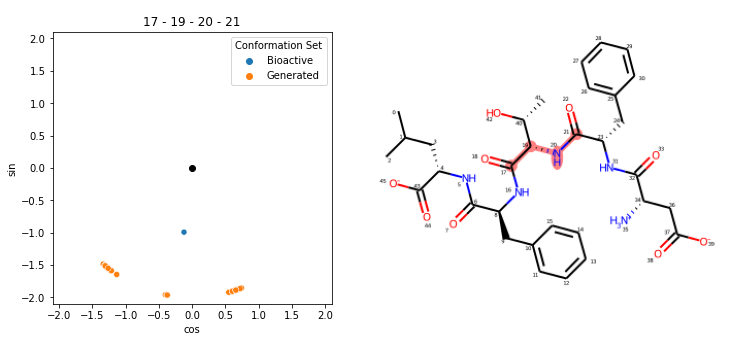

<Figure size 432x288 with 0 Axes>

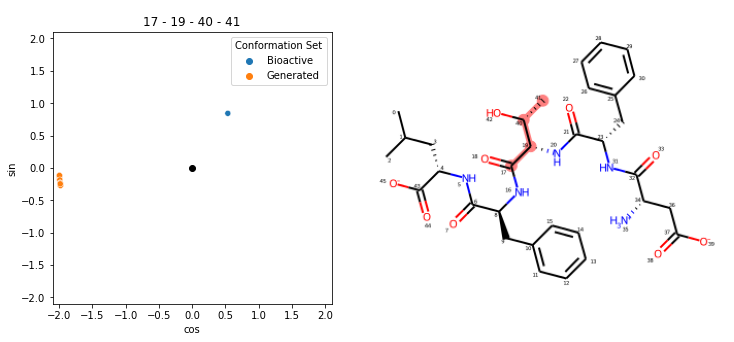

<Figure size 432x288 with 0 Axes>

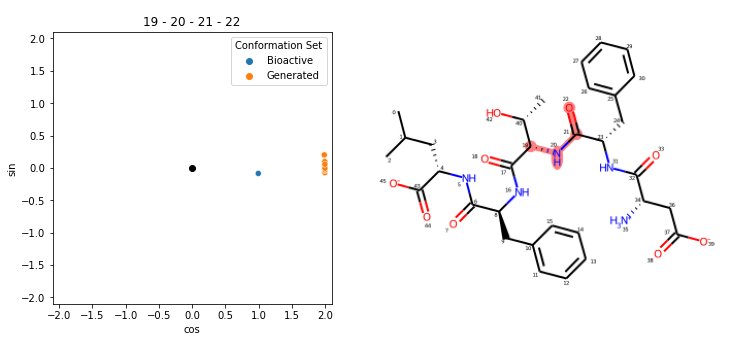

<Figure size 432x288 with 0 Axes>

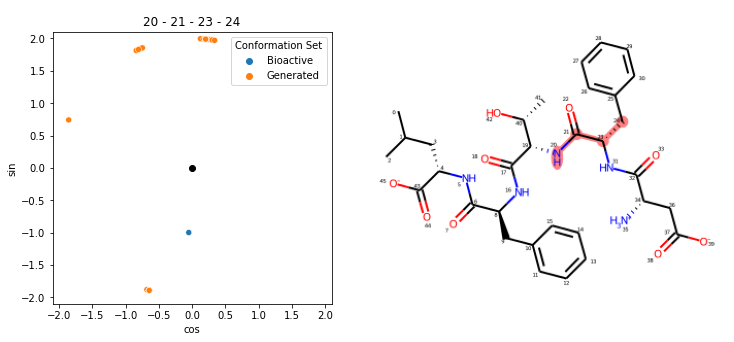

<Figure size 432x288 with 0 Axes>

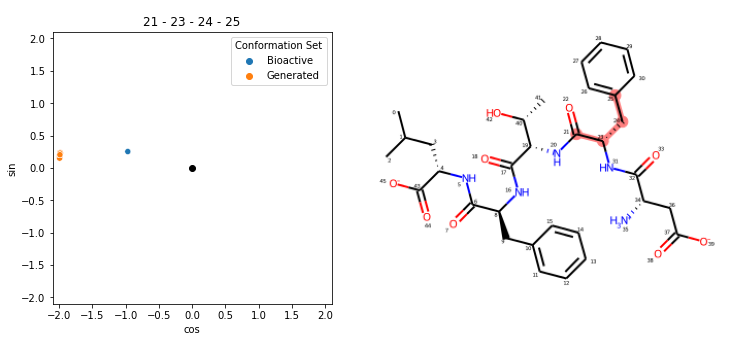

<Figure size 432x288 with 0 Axes>

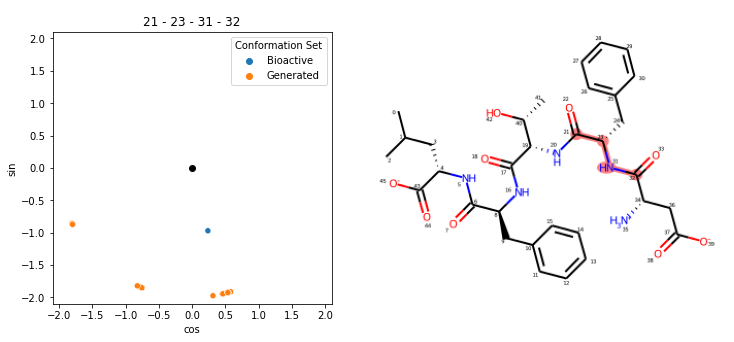

<Figure size 432x288 with 0 Axes>

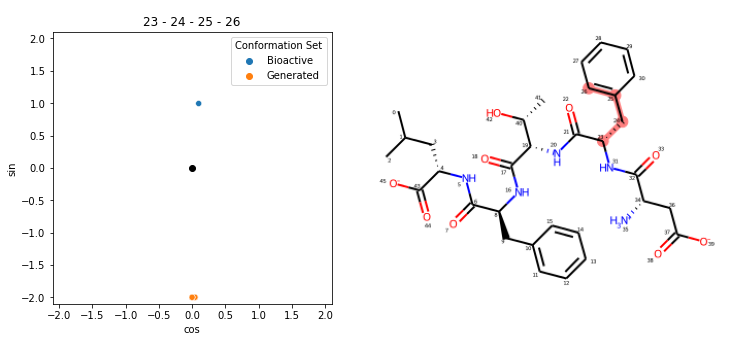

<Figure size 432x288 with 0 Axes>

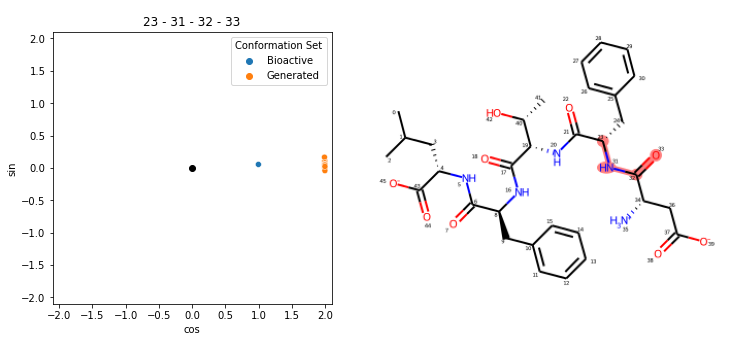

<Figure size 432x288 with 0 Axes>

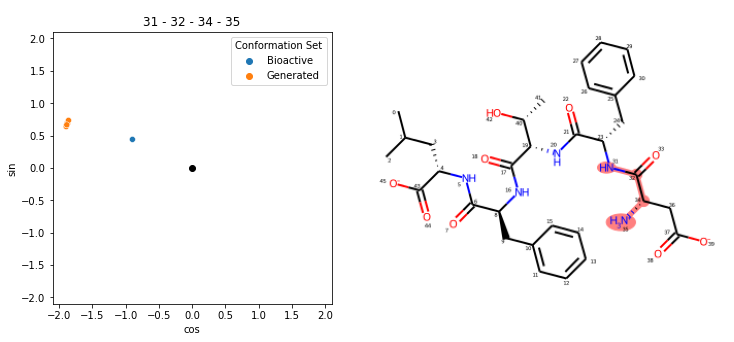

<Figure size 432x288 with 0 Axes>

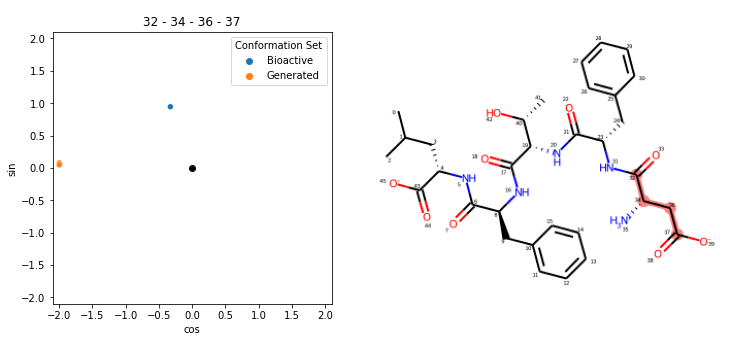

<Figure size 432x288 with 0 Axes>

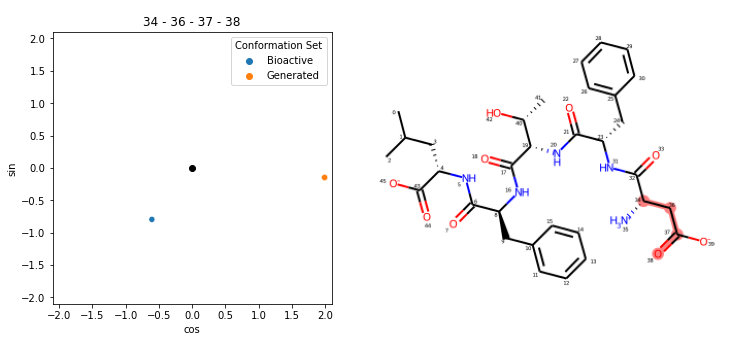

<Figure size 432x288 with 0 Axes>

In [45]:
dihedrals_atom_ids = ca.get_rotatable_bonds_atom_idx(generated_mol)
ca.plot_dihedrals_histograms(dihedrals_atom_ids=dihedrals_atom_ids, mol_dict=mol_dict)

In [ ]:
grouped_ac.min(axis=0)

In [ ]:
rot_bonds = ca.get_rotatable_bonds_atom_idx(test_mol)

In [ ]:
cosins = np.empty((0, generated_mol.GetNumConformers()))
for dihedral_indexes in rot_bonds :
    dihedrals = ca.get_conformers_dihedrals_deg(generated_mol, *dihedral_indexes)
    dihedrals_rad = np.deg2rad(dihedrals)
    coss = np.cos(dihedrals_rad)
    sins = np.sin(dihedrals_rad)
    cosins = np.vstack([cosins, coss, sins])

In [ ]:
data_list = mf.featurize_mol(generated_mol)
batch = Batch.from_data_list(data_list)
ac = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac = ac.reshape(generated_mol.GetNumConformers(), generated_mol.GetNumAtoms())
preds = model(batch)
preds = preds.detach().numpy().reshape(-1)

In [ ]:
cosins = cosins.transpose()

In [ ]:
cosins.shape

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(cosins, preds)

In [ ]:
lr.coef_.max()

In [ ]:
lr.coef_.argsort()

In [ ]:
lr.coef_.min()

In [ ]:
rot_bonds

In [ ]:
rot_bonds[21]

In [ ]:
plt.plot(lr.coef_)

In [ ]:
lr_preds = lr.predict(cosins)

In [ ]:
plt.plot(lr_preds - preds)

In [ ]:
dihedrals_i = ca.get_conformers_dihedrals_deg(test_mol, 16, 17, 19, 20)
dihedrals_j = ca.get_conformers_dihedrals_deg(test_mol, 20, 21, 23, 24)
plt.figure(figsize=(10,10))
sns.scatterplot(x=dihedrals_i, y=dihedrals_j, hue=preds.reshape(-1).detach().numpy())
plt.show()

In [ ]:
dihedrals_i = ca.get_conformers_dihedrals_deg(test_mol, 16, 17, 19, 20)
dihedrals_j = ca.get_conformers_dihedrals_deg(test_mol, 20, 21, 23, 24)
for i in range(grouped_ac.shape[1]) :
    atom_contributions = grouped_ac[:, i]
    sns.scatterplot(x=dihedrals_i, y=dihedrals_j, hue=atom_contributions)
    plt.title(i)
    plt.show()

In [ ]:
dihedrals_atom_ids = [(27, 28, 29, 30), (33, 27, 28, 29), (36, 22, 23, 24)]
ca.plot_dihedrals_histograms(dihedrals_atom_ids=dihedrals_atom_ids, 
                             mol_dict=mol_dict)

In [ ]:
data_list = mf.featurize_mol(train_mol)
batch = Batch.from_data_list(data_list)
ac = model.get_atomic_contributions(batch).detach().numpy()
grouped_ac = ac.reshape(train_mol.GetNumConformers(), train_mol.GetNumAtoms())

In [ ]:
bioactive_mol = copy.deepcopy(train_mol)
bioactive_mol.RemoveAllConformers()
bioactive_mol.AddConformer(train_mol.GetConformer(100), assignId=True)
generated_mol = copy.deepcopy(train_mol)
generated_mol.RemoveConformer(100)

mol_dict = {'Bioactive': bioactive_mol,
            'Generated': generated_mol}

In [ ]:
dihedrals = ca.get_conformers_dihedrals_deg(train_mol, 3, 4, 5, 43)
for i in range(grouped_ac.shape[1]) :
    atom_contributions = grouped_ac[:, i]
    sns.scatterplot(x=dihedrals, y=atom_contributions)
    plt.title(i)
    plt.show()

In [ ]:
dihedrals_atom_ids = [(3, 4, 5, 43)]
ca.plot_dihedrals_histograms(dihedrals_atom_ids=dihedrals_atom_ids, 
                             mol_dict=mol_dict)

In [ ]:
targets = mf.get_bioactive_rmsds(train_mol)
preds = model(batch)

In [ ]:
x = targets.detach().numpy()
y = preds.reshape(-1).detach().numpy()
r2 = r2_score(x, y)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=x, y=y)
plt.xlim(-0.2, 6.2)
plt.ylim(-0.2, 6.2)
plt.xlabel('Target ARMSD')
plt.ylabel('Predicted ARMSD')
plt.title(f'R2: {r2:.2f}')
plt.tight_layout()
plt.savefig('large_mol_regression_train.png', dpi=300)

In [ ]:
sdwriter = Chem.SDWriter('test_mol.sdf')
for conf_id in [99, 100] :
    sdwriter.write(test_mol, confId=conf_id)
sdwriter.close()

In [ ]:
sdwriter = Chem.SDWriter('train_mol.sdf')
for conf_id in [99, 100] :
    sdwriter.write(test_mol, confId=conf_id)
sdwriter.close()

# Largest regression RMSE

In [ ]:
rmses = []
for smiles, results in conf_results.items() :
    rmses.extend(results['rmse'])

In [ ]:
max_rmse_idx = np.argmax(rmses)

In [ ]:
max_rmse = rmses[max_rmse_idx]
max_rmse

In [ ]:
for smiles, results in conf_results.items() :
    if max_rmse in results['rmse'] :
        print(smiles)
        break

In [ ]:
ce = cel.load_ensemble_from_smiles(smiles, load_dir='merged')
pdb_id = ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

In [ ]:
sns.scatterplot(x=results['targets'], y=results['preds'])
plt.xlim(-0.2)
plt.ylim(-0.2)

In [ ]:
properties = {'RMSE' : results['rmse'],
              'ARMSD' : results['targets'],
              'Predicted ARMSD' : results['preds'],
              'UFF Energy' : results['energies']}
conf_id_slider = mcv.view(ce.mol,
                         properties=properties)

In [ ]:
mean_rmses = []
for smiles, results in conf_results.items() :
    mol_res = mol_results[smiles]
    if 'rmse_all' in mol_res :
        mean_rmse = mol_res['rmse_all']
        mean_rmses.append(mean_rmse)

In [ ]:
max_rmse_idx = np.argmax(mean_rmses)

In [ ]:
max_rmse = mean_rmses[max_rmse_idx]

In [ ]:
for smiles, results in conf_results.items() :
    mol_res = mol_results[smiles]
    if 'rmse_all' in mol_res :
        mean_rmse = mol_res['rmse_all']
        if max_rmse == mean_rmse :
            print(smiles)
            break

In [ ]:
ce = cel.load_ensemble_from_smiles(smiles, load_dir='merged')
pdb_id = ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

In [ ]:
sns.scatterplot(x=results['targets'], y=results['preds'])
plt.xlim(-0.2)
plt.ylim(-0.2)

In [ ]:
properties = {'RMSE' : results['rmse'],
              'ARMSD' : results['targets'],
              'Predicted ARMSD' : results['preds'],
              'UFF Energy' : results['energies']}
conf_id_slider = mcv.view(ce.mol,
                         properties=properties)

In [ ]:
test_fp = AllChem.GetMorganFingerprint(ce.mol, 3, useChirality=True)
sims = []
for train_fp in train_fps :
    dice_sim = DataStructs.TanimotoSimilarity(test_fp, train_fp)
    sims.append(dice_sim)
max_sim = max(sims)
max_sim_idx = np.argmax(sims)
sim_smiles = train_smiles[max_sim_idx]

sim_ce = cel.load_ensemble_from_smiles(sim_smiles, load_dir='merged')
pdb_id = sim_ce.mol.GetProp('PDB_ID')
table[table['PDB code'] == pdb_id]

mf = MoleculeFeaturizer()
model = get_model()
model.eval()
data_list = mf.featurize_mol(sim_ce.mol)
targets = mf.get_bioactive_rmsds(sim_ce.mol).numpy()

batch = Batch.from_data_list(data_list)
preds = model(batch).detach().numpy().squeeze()
errors = np.abs(targets - preds)

properties = {'RMSE' : errors,
              'ARMSD' : targets,
              'Predicted ARMSD' : preds,
              'UFF Energy' : batch.energy.numpy()}
mcv.view(sim_ce.mol,
         properties=properties)

In [ ]:
new_mol = copy.deepcopy(sim_ce.mol)

In [ ]:
d2d = rdMolDraw2D.MolDraw2DCairo(700, 700)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(new_mol)
d2d.FinishDrawing()
d2d.WriteDrawingText('mol.png') 

In [ ]:
AlignMolConformers(new_mol, atomIds=list(range(2, 34)))

In [ ]:
mcv.view(new_mol,
         properties=properties)

In [ ]:
batch

In [ ]:
mcs = rdFMCS.FindMCS([ce.mol, sim_ce.mol])

In [ ]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol
mol_with_atom_index(core)

In [ ]:
mol_copy = copy.deepcopy(ce.mol)
mol_copy.RemoveAllConformers()
mol_with_atom_index(mol_copy)

In [ ]:
core = Chem.MolFromSmarts(mcs.smarts)
mol1_atoms = ce.mol.GetSubstructMatches(core)[0]
mol2_atoms = sim_ce.mol.GetSubstructMatches(core)[0]
atom_map = list(zip(mol1_atoms, mol2_atoms))

In [ ]:
for i in range(ce.mol.GetNumConformers()) :
    AlignMol(ce.mol, sim_ce.mol, i, 3, atomMap=atom_map)

In [ ]:
properties = {'RMSE' : results['rmse'],
              'ARMSD' : results['targets'],
              'Predicted ARMSD' : results['preds'],
              'UFF Energy' : results['energies']}
mcv.view(ce.mol, properties)
mcv.view(sim_ce.mol)